<a id='modules'></a> 
### Import modules
These contain all the functions we will be using for the analysis

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

<a id='specifydirectory'></a> 
### Specify experiment directory
- Experimental conditions are named after the folders in the directory
- Channel numbers of each condition (ECM, synapses, nuclei) is read from the file channels.txt in the directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Nikon_liveON/' #master folder
protein="tnr" #TNR,Agg,WFA,HABP

<a id='makedict'></a> 
### Make an empty dictionary to store all the results we want to calculate

In [4]:
results = {"path":[],
           "expname":[],
           "exp_date":[],
           "cell_no":[],
           "exp_condition":[],
           "timepoint":[],
           "soma_masked_image":[],
           "values_under_soma_mask":[],
           "background from full images":[],
          "values_soma_after_bg_subtraction":[],
          "neurite_linescan_coordinates":[],
          "values_under_neurite_linescan":[],
          "values_neurite_linescan_after_bg_subtraction":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "Analyze" in str(filelist[i]):
        if ("bg_value" in str(filelist[i]))==True:
            if ("linescan" in str(filelist[i]))==False:
                if filelist[i].endswith(".mat"): 
                    results["path"].append(filelist[i])
                    results["expname"].append(filelist[i].split('/')[-2])
                    results["exp_date"].append(filelist[i].split('/')[-2][0:6])
                    results["cell_no"].append(filelist[i].split('/')[-1][-14:-13])
                    if ("Blocked_plus4hrs" in str(filelist[i]))==True:
                        results["exp_condition"].append("Blocked")
                    elif ("All_epitopes" in str(filelist[i]))==True:
                        results["exp_condition"].append("Unblocked")

                    results["timepoint"].append(filelist[i].split('/')[-1][-21:-20])

                    #soma
                    firstpart=filelist[i][:-12]
                    file2read=firstpart+'maskedimage.mat'
                    results["soma_masked_image"].append(np.asarray(spio.loadmat(file2read)["masked_image"]))
                    file2read=firstpart+'image_under_mask.mat'
                    results["values_under_soma_mask"].append(np.asarray(spio.loadmat(file2read)["undermask"]))
                    results["background from full images"].append(np.asarray(spio.loadmat(filelist[i])["bg"]))
                    #soma - bg
                    rawvalues=np.asarray(spio.loadmat(file2read)["undermask"])
                    bg=np.asarray(spio.loadmat(filelist[i])["bg"])
                    bgsubtracted=rawvalues-bg
                    bgsubtracted[bgsubtracted<0]=0
                    results["values_soma_after_bg_subtraction"].append(bgsubtracted)
                    #linescan
                    file2read=firstpart+'neuritelinescan_linecoordinates_mask.mat'
                    results["neurite_linescan_coordinates"].append(np.asarray(spio.loadmat(file2read)["linecoordinates"]))
                    file2read=firstpart+'neuritelinescan_lineprofileintensity_mask.mat'
                    results["values_under_neurite_linescan"].append(np.asarray(spio.loadmat(file2read)["intensity"]))
                    #linescan-bg
                    rawvalues=np.asarray(spio.loadmat(file2read)["intensity"])
                    bgsubtracted=rawvalues-bg
                    bgsubtracted[bgsubtracted<0]=0
                    results["values_neurite_linescan_after_bg_subtraction"].append(bgsubtracted)

**Let's take a look at which experimental conditions we have**

In [5]:
print("\n".join(list(sorted(set(results["exp_condition"])))))

Blocked
Unblocked


<a id='quantitativeimageanalysis'></a> 
### Quanitative image analysis

Now we can extract some numbers from our processed images. We'll extract a lot of data - you never know what could be interesting, and we don't have to use it all.

Beforehand, we will calculate the mean intensity of the non-blocked control images, so that we can use this later in the analysis

<a id='plots'></a> 
## Visualization - plots

Now we can make some plots from our data to understand the results. To do this we will first convert our results dictionary into a python *DataFrame*. This is a format used in the Python package Pandas, and it's very handy for data analysis and plotting. It's similar to a spreadsheet (e.g. Excel), except that each cell can hold any type of data you want, even matrices.

In [10]:
df=pd.DataFrame(results)
df['timepoint']=df['timepoint'].apply(int)
df['cell_no']=df['cell_no'].apply(int)
df["soma mean intensity after bg subtract"]=[np.mean(x) for x in df["values_soma_after_bg_subtraction"]]
df["soma mean intensity"]=[np.mean(x) for x in df["values_under_soma_mask"]]
df["neurite linescan mean intensity after bg subtract"]=[np.mean(x) for x in df["values_neurite_linescan_after_bg_subtraction"]]
df["neurite linescan mean intensity"]=[np.mean(x) for x in df["values_under_neurite_linescan"]]

In [11]:
#normalized values (divided by first time point)
df["normd soma mean intensity after bg subtract"]=df["soma mean intensity after bg subtract"]
df["normd soma mean intensity"]=df["soma mean intensity"]
df["normd neurite linescan mean intensity after bg subtract"]=df["neurite linescan mean intensity after bg subtract"]
df["normd neurite linescan mean intensity"]=df["neurite linescan mean intensity"]
for exp in df["expname"].unique():
    for cell in df[df["expname"]==exp]["cell_no"].unique(): 
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["soma mean intensity after bg subtract"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd soma mean intensity after bg subtract"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd soma mean intensity after bg subtract"]/firsttimepoint.values[0]
        
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["soma mean intensity"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd soma mean intensity"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd soma mean intensity"]/firsttimepoint.values[0]
    
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["neurite linescan mean intensity after bg subtract"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd neurite linescan mean intensity after bg subtract"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd neurite linescan mean intensity after bg subtract"]/firsttimepoint.values[0]
    
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["neurite linescan mean intensity"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd neurite linescan mean intensity"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd neurite linescan mean intensity"]/firsttimepoint.values[0]
    

Before continuing, we will make a new folder called 'results' inside our experiment folder, and backup the dataframes as csv (comma separated value) files:

In [12]:
#os.mkdir(expdir+'_results/')
df.to_csv(path_or_buf=expdir+'_results/results_csv')

**Load an existing DataFrame**
If we want to plot the results that we already created and saved, we can load the csv file and convert it back into a DataFrame:

In [3]:
df=pd.read_csv(expdir+'_results/results_'+str(results["expname"])+'.csv')

NameError: name 'results' is not defined

<a id='checknormality'></a> 
**How does the intensity distribute?**

In [219]:
df.columns

Index(['path', 'expname', 'exp_date', 'cell_no', 'exp_condition', 'timepoint',
       'soma_masked_image', 'values_under_soma_mask',
       'background from full images', 'values_soma_after_bg_subtraction',
       'neurite_linescan_coordinates', 'values_under_neurite_linescan',
       'values_neurite_linescan_after_bg_subtraction',
       'soma mean intensity after bg subtract', 'soma mean intensity',
       'neurite linescan mean intensity after bg subtract',
       'neurite linescan mean intensity',
       'normd soma mean intensity after bg subtract',
       'normd soma mean intensity',
       'normd neurite linescan mean intensity after bg subtract',
       'normd neurite linescan mean intensity'],
      dtype='object')

<class 'numpy.ndarray'>
The variable does not distribute normally


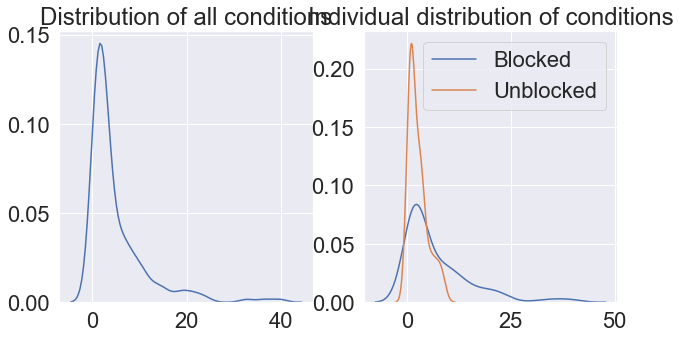

In [22]:
variable="normd soma mean intensity after bg subtract" #change me

x=df[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

    sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp_condition"])):
    sns.kdeplot(df[df["exp_condition"]==condition][variable],legend=False)
    
    plt.legend(list(set(df["exp_condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    

#### Defining variables to plot from dataframe

In [14]:
df.head()

,path,expname,exp_date,cell_no,exp_condition,timepoint,soma_masked_image,values_under_soma_mask,background from full images,values_soma_after_bg_subtraction,...,values_under_neurite_linescan,values_neurite_linescan_after_bg_subtraction,soma mean intensity after bg subtract,soma mean intensity,neurite linescan mean intensity after bg subtract,neurite linescan mean intensity,normd soma mean intensity after bg subtract,normd soma mean intensity,normd neurite linescan mean intensity after bg subtract,normd neurite linescan mean intensity
0,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,20190304_tnrunblocked,201903,1,Unblocked,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[857.0], [776.3316687474036], [874.0], [829.0...",[[892.572690752957]],"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",...,"[[798.0], [734.4215563878911], [773.0], [872.0...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....",170.503524,1054.106638,108.490482,980.162682,1.000000,1.000000,1.000000,1.000000
1,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,20190304_tnrunblocked,201903,1,Unblocked,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1150], [1094], [1077], [1112], [1040], [1043...",[[926.457612915039]],"[[223.54238708496098], [167.54238708496098], [...",...,"[[1084], [988], [1006], [1068], [1060], [1010]...","[[157.54238708496098], [61.54238708496098], [7...",152.864596,1059.502445,71.977696,993.325000,0.896548,1.005119,0.663447,1.013429
2,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,20190304_tnrunblocked,201903,1,Unblocked,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1012], [1102], [983], [1086], [1029], [1081]...",[[971.6296701049805]],"[[40.370329895019495], [130.3703298950195], [1...",...,"[[1078], [967], [923], [854], [871], [931], [8...","[[106.3703298950195], [0.0], [0.0], [0.0], [0....",362.871666,1322.954974,46.108617,1001.075000,2.128236,1.255049,0.425001,1.021336
3,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,20190304_tnrunblocked,201903,1,Unblocked,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1995], [1860], [1942], [1895], [1894], [1706...",[[1037.9299699401856]],"[[957.0700300598144], [822.0700300598144], [90...",...,"[[1059], [1053], [1037], [1076], [1022], [994]...","[[21.07003005981437], [15.070030059814371], [0...",684.631182,1710.752249,48.926355,1075.250000,4.015349,1.622940,0.450974,1.097012
4,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/L...,20190304_tnrunblocked,201903,1,Unblocked,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1108], [1034], [1094], [1118], [1013], [1047...",[[1078.971033782959]],"[[29.02896621704099], [0.0], [15.0289662170409...",...,"[[1135], [1061], [1025], [1263], [1007], [1081...","[[56.02896621704099], [0.0], [0.0], [184.02896...",927.154591,1995.633198,114.949621,1186.225000,5.437744,1.893199,1.059536,1.210233


In [23]:
vars2plot=df._get_numeric_data().columns #gives the names of the numeric columns only

### Plot bg subtracted intensity as a function of time, for each cell

In [16]:
df.columns

Index(['path', 'expname', 'exp_date', 'cell_no', 'exp_condition', 'timepoint',
       'soma_masked_image', 'values_under_soma_mask',
       'background from full images', 'values_soma_after_bg_subtraction',
       'neurite_linescan_coordinates', 'values_under_neurite_linescan',
       'values_neurite_linescan_after_bg_subtraction',
       'soma mean intensity after bg subtract', 'soma mean intensity',
       'neurite linescan mean intensity after bg subtract',
       'neurite linescan mean intensity',
       'normd soma mean intensity after bg subtract',
       'normd soma mean intensity',
       'normd neurite linescan mean intensity after bg subtract',
       'normd neurite linescan mean intensity'],
      dtype='object')

(-1, 20)

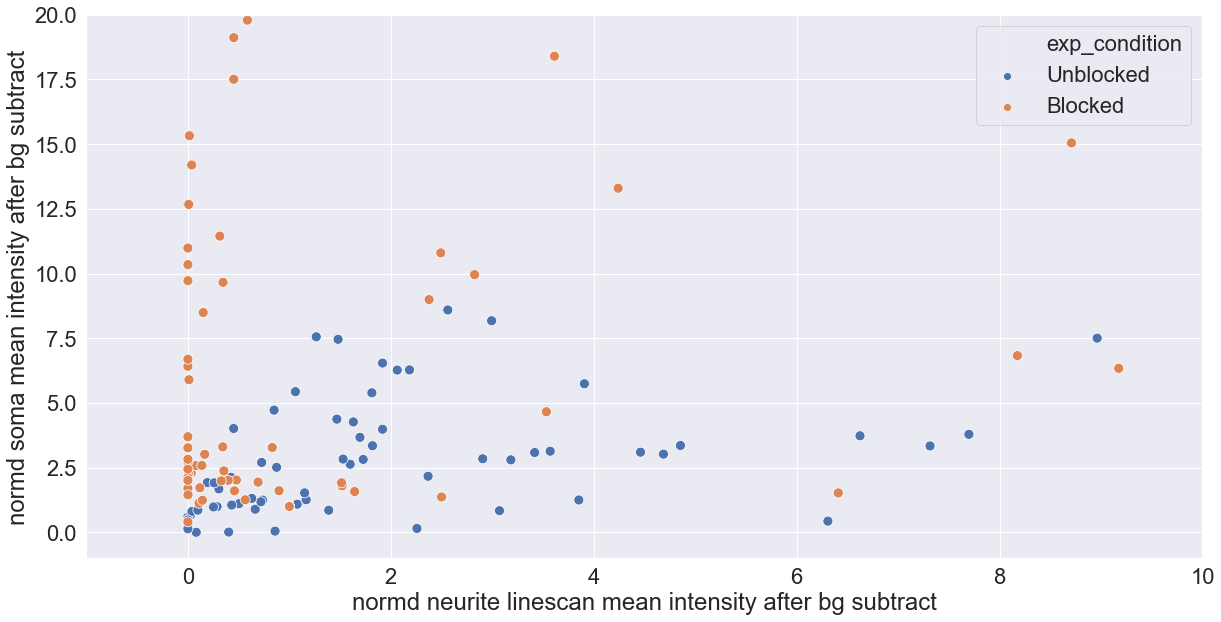

In [24]:
df2plot=df[df["timepoint"]<9]
sns.set(font_scale=2)
fig=plt.figure(figsize=(20,10))
g=sns.scatterplot(x="normd neurite linescan mean intensity after bg subtract", y="normd soma mean intensity after bg subtract", 
              hue="exp_condition", data=df2plot,s=100)
g.set_xlim([-1,10])
g.set_ylim([-1,20])


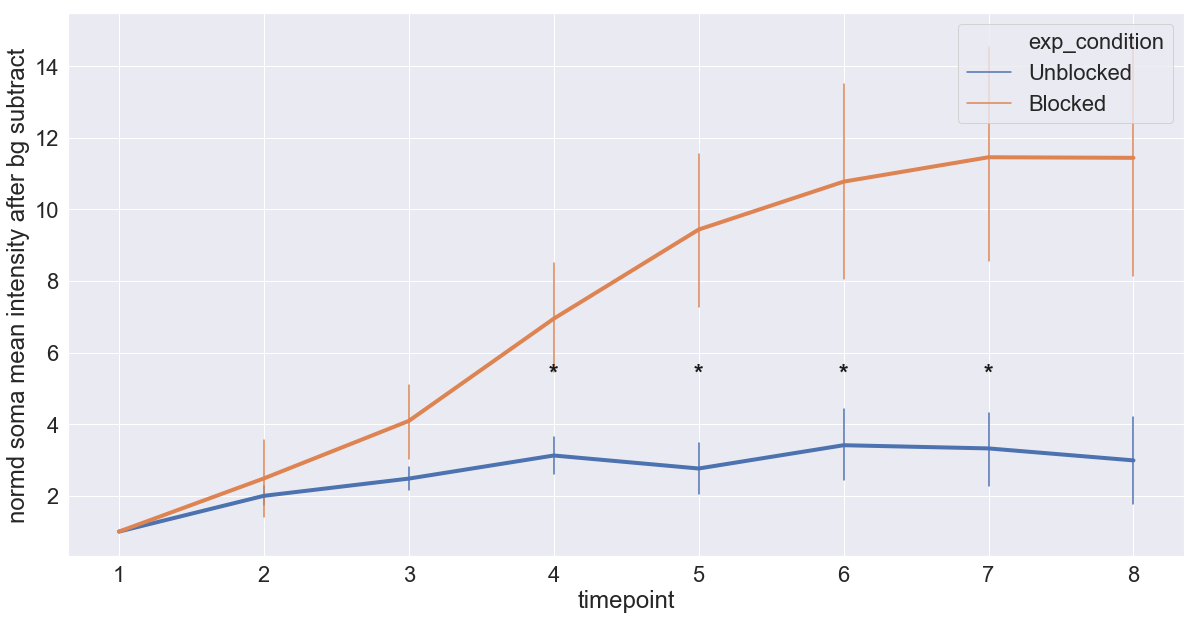

In [31]:
y_axis="normd soma mean intensity after bg subtract"

df2plot=df[df["timepoint"]<9]
sns.set(font_scale=2)
fig=plt.figure(figsize=(20,10))
g=sns.lineplot(x="timepoint", y=y_axis, hue="exp_condition", data=df2plot,linewidth=4,
             err_style="bars",ci=68);

counter=0.5
for timepoint in df_to_plot["timepoint"].unique():
    control=df_to_plot[(df_to_plot["timepoint"]==timepoint)&(df_to_plot["exp_condition"]=="Unblocked")][y_axis]
    blocked=df_to_plot[(df_to_plot["timepoint"]==timepoint)&(df_to_plot["exp_condition"]=="Blocked")][y_axis]
    [stat,pval]=stats.ttest_ind(control, blocked)
    #bonferroni correction, but divide by 2 for directional ttest
    #plot
    
    col='k'
    y=df2plot[y_axis].mean()
    h=0
    x1,x2=counter,counter+1
    if pval<0.001:
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
    elif pval<0.01:
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
    elif pval<0.05:
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')
    #else:
     #   plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=10, weight='bold')
    counter+=1
    
    

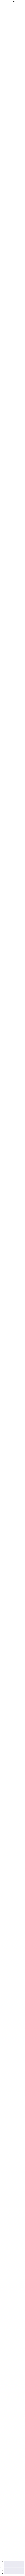

In [19]:
df_to_plot=df[df["timepoint"]<9]
y_axis="normd soma mean intensity after bg subtract"
for timepoint in df_to_plot["timepoint"].unique():
    control=df_to_plot[(df_to_plot["timepoint"]==timepoint)&(df_to_plot["exp_condition"]=="Unblocked")][y_axis]
    blocked=df_to_plot[(df_to_plot["timepoint"]==timepoint)&(df_to_plot["exp_condition"]=="Blocked")][y_axis]
    [stat,pval]=stats.ttest_ind(control, blocked)
    #bonferroni correction, but divide by 2 for directional ttest
    #plot
    counter=0
    col='k'
    y=200
    h=0
    x1,x2=counter,counter+1
    if pval<0.001:
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.01:
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.05:
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
    else:
        plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')
    counter+=1

In [21]:
y_axis="normd soma mean intensity after bg subtract"
for timepoint in df2plot["timepoint"].unique():
    control=df_to_plot[(df_to_plot["timepoint"]==timepoint)&(df_to_plot["exp_condition"]=="Unblocked")][y_axis]
    blocked=df_to_plot[(df_to_plot["timepoint"]==timepoint)&(df_to_plot["exp_condition"]=="Blocked")][y_axis]
    [stat,pval]=stats.ttest_ind(control, blocked)
    #bonferroni correction, but divide by 2 for directional ttest
    pval=pval*len(np.unique(df_to_plot["Time"]))/2
    #plot
    x1, x2 = counter, counter+0.4 
    y= 1.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    h=0.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    col='k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
    if pval<0.001:
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.01:
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.05:
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
    else:
        plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')
        counter+=1

KeyError: 'Time'

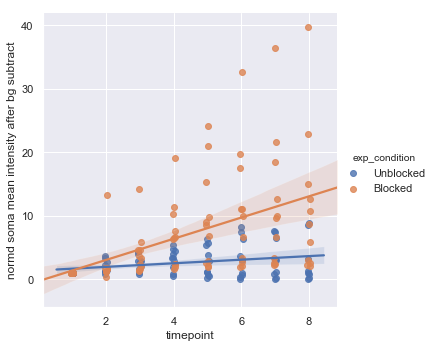

In [422]:
sns.lmplot(x="timepoint", y="normd soma mean intensity after bg subtract", hue="exp_condition",data=df2plot, x_jitter=.05);

### Bleach correction

In [277]:
#load fixed control 
ctrl_results = {"path":[],
           "expname":[],
           "exp_date":[],
           "cell_no":[],
           "exp_condition":[],
           "timepoint":[],
           "soma_masked_image":[],
           "values_under_soma_mask":[],
           "background from full images":[],
            "values_soma_after_bg_subtraction":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "fixedctrl" in str(filelist[i]):
        if ("bg_value" in str(filelist[i]))==True:
            if ("linescan" in str(filelist[i]))==False:
                if filelist[i].endswith(".mat"): 
                    ctrl_results["path"].append(filelist[i])
                    ctrl_results["expname"].append(filelist[i].split('/')[-2])
                    ctrl_results["exp_date"].append(filelist[i].split('/')[-2][0:6])
                    ctrl_results["cell_no"].append(filelist[i].split('/')[-1][-14:-13])
                    if ("Blocked_plus4hrs" in str(filelist[i]))==True:
                        ctrl_results["exp_condition"].append("Blocked")
                    elif ("All_epitopes" in str(filelist[i]))==True:
                        ctrl_results["exp_condition"].append("Unblocked")
                    elif ("fixedctrl" in str(filelist[i]))==True:
                        ctrl_results["exp_condition"].append("Fixed_Control")

                    ctrl_results["timepoint"].append(filelist[i].split('/')[-1][-21:-20])

                    #soma
                    firstpart=filelist[i][:-12]
                    file2read=firstpart+'maskedimage.mat'
                    ctrl_results["soma_masked_image"].append(np.asarray(spio.loadmat(file2read)["masked_image"]))
                    file2read=firstpart+'image_under_mask.mat'
                    ctrl_results["values_under_soma_mask"].append(np.asarray(spio.loadmat(file2read)["undermask"]))
                    ctrl_results["background from full images"].append(np.asarray(spio.loadmat(filelist[i])["bg"]))
                    #soma - bg
                    rawvalues=np.asarray(spio.loadmat(file2read)["undermask"])
                    bg=np.asarray(spio.loadmat(filelist[i])["bg"])
                    bgsubtracted=rawvalues-bg
                    bgsubtracted[bgsubtracted<0]=0
                    ctrl_results["values_soma_after_bg_subtraction"].append(bgsubtracted)

#### Make an exponential fit of non-biological bleaching (time lapse imaging of fixed cells)

In [385]:
df_control=pd.DataFrame(ctrl_results)
df_control['timepoint']=df_control['timepoint'].apply(int)
df_control['cell_no']=df_control['cell_no'].apply(int)
df_control["soma mean intensity after bg subtract"]=[np.mean(x) for x in df_control["values_soma_after_bg_subtraction"]]
df_control["soma mean intensity"]=[np.mean(x) for x in df_control["values_under_soma_mask"]]
#normalized values (divided by first time point)
df_control["normd soma mean intensity after bg subtract"]=df_control["soma mean intensity after bg subtract"]
df_control["normd soma mean intensity"]=df_control["soma mean intensity"]
for exp in df_control["expname"].unique():
    for cell in df_control[df_control["expname"]==exp]["cell_no"].unique(): 
        firsttimepoint=df_control[(df_control["expname"]==exp)&(df_control["timepoint"]==1)&(df_control["cell_no"]==cell)]["soma mean intensity after bg subtract"]
        df_control.loc[(df_control["expname"]==exp)&(df_control["cell_no"]==cell),"normd soma mean intensity after bg subtract"]=df_control[(df_control["expname"]==exp)&(df_control["cell_no"]==cell)]["normd soma mean intensity after bg subtract"]/firsttimepoint.values[0]
        
        firsttimepoint=df_control[(df_control["expname"]==exp)&(df_control["timepoint"]==1)&(df_control["cell_no"]==cell)]["soma mean intensity"]
        df_control.loc[(df_control["expname"]==exp)&(df_control["cell_no"]==cell),"normd soma mean intensity"]=df_control[(df_control["expname"]==exp)&(df_control["cell_no"]==cell)]["normd soma mean intensity"]/firsttimepoint.values[0]

<Figure size 1440x720 with 0 Axes>

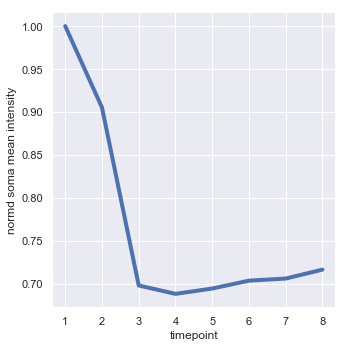

In [386]:
fig=plt.figure(figsize=(20,10))
sns.relplot(x="timepoint", y="normd soma mean intensity", kind="line", data=df_control,linewidth=4);

In [394]:
df_control["timepoint"].values

array([1, 2, 3, 4, 5, 6, 7, 8])

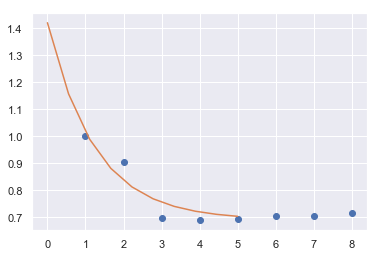

In [400]:

import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
import numpy as np
from scipy.optimize import curve_fit



x=df_control["timepoint"].values
y=df_control["normd soma mean intensity"].values

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c


popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))

xx = np.linspace(0, 5, 10)
yy = exponenial_func(xx, *popt)

plt.plot(x,y,'o', xx, yy)


### fluorescence change corrected by bleaching

In [410]:
df["bleach value"]=np.nan
for timepoint in df["timepoint"].unique():
    df.loc[df["timepoint"]==timepoint,"bleach value"]=exponenial_func(timepoint, *popt)

In [412]:
df["normd soma mean intensity after bg subtract, corrected"]=df["soma mean intensity after bg subtract"]
df["normd soma mean intensity, corrected"]=df["soma mean intensity"]
df["normd soma mean intensity after bg subtract, corrected"]-=df["bleach value"]

In [464]:
df["normd neurite linescan mean intensity after bg subtract, corrected"]=df["neurite linescan mean intensity after bg subtract"]
df["normd neurite linescan mean intensity, corrected"]=df["neurite linescan mean intensity"]
df["normd neurite linescan mean intensity after bg subtract, corrected"]-=df["bleach value"]

<a id='makingsense'></a> 
### Making sense

Let's add some human-understandable tags to the DataFrame, so that we can plot what we want more easily.
- A tag for the incubation time
- A tag for the treatment condition (Bic/DMSO)

In [ ]:
df2=deepcopy(df)
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hrs'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'Time'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'Time'] = '4hrs'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'Time'] = '22hrs'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df2['Condition']='None'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr'
df2.loc[df2['exp condition'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df2.loc[df2['exp condition'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr'
df2.loc[df2['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df2.loc[df2['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'

**Bic versus DMSO Pointplot across time**

We can also plot the mean intensity as a function of time using a point plot. Let's do this separately for the different treatments:

In [ ]:
orderlab=['2hrs','4hrs','12hrs']
sns.set(font_scale=1)
sns.set_palette("Paired", 2)
sns.set_style("whitegrid")
for var2plot in vars2plot:
    if not "channelno" in str(var2plot):
        if not "Unnamed" in str(var2plot):
            fig=plt.figure()
            d=sns.pointplot(y=var2plot, x='Time',data=df2[df2["Drug"]!="None"],hue='Drug',
                            hue_order=['DMSO','Bic'],split=True,order=orderlab,ci=None)
            plt.title(var2plot, y=1.05, fontsize = 14)
            d.set_ylabel('') 
            plt.locator_params(axis='y', nbins=5)
            d.grid(False)
            plt.errorbar(x=[0,1,2],
                     y=[df2[(df2["Drug"]=="Bic")&(df2["Time"]=="2hrs")][var2plot].mean(),
                        df2[(df2["Drug"]=="Bic")&(df2["Time"]=="4hrs")][var2plot].mean(),
                            df2[(df2["Drug"]=="Bic")&(df2["Time"]=="12hrs")][var2plot].mean()],
                            yerr=[df2[(df2["Drug"]=="Bic")&(df2["Time"]=="2hrs")][var2plot].sem(),
                                  df2[(df2["Drug"]=="Bic")&(df2["Time"]=="4hrs")][var2plot].sem(),
                            df2[(df2["Drug"]=="Bic")&(df2["Time"]=="12hrs")][var2plot].sem()],
                            xerr=None,ecolor='dodgerblue',fmt='none',capsize=2)
            plt.errorbar(x=[0,1,2],
                      y=[df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="2hrs")][var2plot].mean(),
                         df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="4hrs")][var2plot].mean(),
                            df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="12hrs")][var2plot].mean()],
                            yerr=[df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="2hrs")][var2plot].sem(),
                                  df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="4hrs")][var2plot].sem(),
                            df2[(df2["Drug"]=="DMSO")&(df2["Time"]=="12hrs")][var2plot].sem()],
                            xerr=None,ecolor='lightblue',fmt='none',capsize=2)
            #d.set_yscale('log')

#### Bic-versus-DMSO boxplot across time

In [ ]:
orderlab=['2hrs','4hrs','12hrs']
sns.set(font_scale=1.3)
sns.set_palette("Paired", 2)
sns.set_style("whitegrid")
sns.despine()
for var2plot in vars2plot:
    if not 'channelno' in str(var2plot):
        fig=plt.figure(figsize=(20,5))
        fig.add_subplot(121)
        d=sns.boxplot(y=var2plot,x="Time",data=df2,linewidth=4,hue="Drug",order=orderlab)
        d.grid(False)
        d.set_yscale('log')
        plt.title('No outlier removal')
        fig.add_subplot(122)
        data_noout=remove_outlier(df2,var2plot)
        d=sns.boxplot(y=var2plot,x="Time",data=data_noout,linewidth=4,hue="Drug",order=orderlab)
        c
        plt.title('With outlier removal')

## Boxplots for matlab masked ROIs: general increase, and split by treatment

In [ ]:
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
sns.despine()
sns.set_palette("Set2")
df_to_plot=df2
hueselector=None
x_labels="Time"
y_axis="ECM mean intensity after bg subtraction: icy mask only"
plot_order=["2hrs","4hrs","12hrs", "Unblocked Control"]   
#plot
fig=plt.figure(figsize=(28,14))
fig.add_subplot(121)
d=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=7,
              hue=hueselector,order=plot_order,hue_order=['Bic','DMSO'],width=0.4)
d.set_ylim([0.8*df_to_plot[y_axis].min(), 0.75*df_to_plot[y_axis].max()])
d.set_xticklabels(d.get_xticklabels(),rotation=45,weight='bold',size=28)
plt.title('')
plt.locator_params(axis='y', nbins=5)
d.set_ylabel('Fluorescence Intensity (AU)',weight='bold',size=28,labelpad=65)
d.set_xlabel('')
d.grid(False)
fig.add_subplot(122)
sns.set_palette("Paired", 2)
df_to_plot=df2[df2["Time"]!="None"]
hueselector="Drug"
x_labels="Time"
plot_order=["2hrs","4hrs","12hrs"]    
g=sns.boxplot(y=y_axis,x=x_labels,data=df_to_plot,linewidth=5,hue=hueselector,order=plot_order,
              hue_order=['Bic','DMSO'],width=0.4)
g.set_xticklabels(g.get_xticklabels(),rotation=45,weight='bold',size=28)
plt.legend(fontsize=38)
plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=False)
g.set_ylabel('')
g.set_xlabel('')
g.grid(False)
#statistics
df_to_plot=df2[df2["Time"]!="None"]
#3 t tests with bonferonni
counter=-0.2
for timepoint in plot_order:
    untreated=df_to_plot[(df_to_plot["Time"]==timepoint)&(df_to_plot["Drug"]=="DMSO")][y_axis]
    bic=df_to_plot[(df_to_plot["Time"]==timepoint)&(df_to_plot["Drug"]=="Bic")][y_axis]
    [stat,pval]=stats.ttest_ind(untreated, bic)
    #bonferroni correction, but divide by 2 for directional ttest
    pval=pval*len(np.unique(df_to_plot["Time"]))/2
    #plot
    x1, x2 = counter, counter+0.4 
    y= 1.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    h=0.05*df_to_plot[df_to_plot["Time"]==timepoint][y_axis].max()
    col='k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
    if pval<0.001:
        plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.01:
        plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=28, weight='bold')
    elif pval<0.05:
        plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')
    else:
        plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=28, weight='bold')
        counter+=1